DATA: Web Traffic Dataset

- Source: Generated by applying a Berkeley Packet Filter to a mirror of the traffic passing through the border router of Indiana University.
- Date range: Nov. 1, 2009 to November 22. 2009
- File size: 235M requests; 2.7GB uncompressed

Meiss, M. R., Menczer, F., Fortunato, S., Flammini, A., Vespignani, A., & Ramasco, J. J. (2008). Web Traffic Dataset [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4487194

In [1]:
# import packages
import pandas as pd
import numpy as np
import json

import pyspark

from pyspark.sql import SparkSession

from pyspark.sql.functions import col,isnan, when, count, mean, sum as _sum, from_unixtime, \
from_utc_timestamp, to_utc_timestamp, unix_timestamp, to_timestamp, to_date, hour, minute, second, \
format_string, row_number, lit, date_format, concat_ws, udf, regexp_extract, broadcast

from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.window import Window

import time
import glob

from pyspark.ml.feature import VectorAssembler,  StandardScaler
from pyspark.ml import Pipeline
from xgboost.spark import SparkXGBRegressor
from sklearn.ensemble import IsolationForest
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator


from datetime import datetime, timezone, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



import warnings
warnings.filterwarnings('ignore')

In [2]:
#Starting the session
spark = SparkSession.builder \
    .appName("WebTrafficAnalysis") \
    .config("spark.executor.memory", "20g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "10") \
    .config("spark.driver.maxResultSize", "2560m") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
# hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/28 18:00:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# loading the dataset
start = time.time()
df = spark.read.json("data/*.json")
end = time.time()
print(f"{end-start:.2f} Sec")

5.20 Sec


In [5]:
#show the dataset
df.show()

+-----+--------------------+----------+--------------------+
|count|                from| timestamp|                  to|
+-----+--------------------+----------+--------------------+
|    1|          theybf.com|1257033601|     w.sharethis.com|
|    1|                    |1257033601|           agohq.org|
|    3| twistysdownload.com|1257033601|adserving.cpxinte...|
|    1|   459.cim.meebo.com|1257033601|   459.cim.meebo.com|
|    1|      boards.nbc.com|1257033601| change.menelgame.pl|
|    1|mail3-12.sinamail...|1257033601|mail3-12.sinamail...|
|    3|       mediafire.com|1257033601|  tag.contextweb.com|
|    2|    mp3.rhapsody.com|1257033601|         adready.com|
|    4|artikel-kesehatan...|1257033601|     adsensecamp.com|
|    1|                    |1257033601|         mlbland.com|
|    1|shortlonghairstyl...|1257033601|   c.statcounter.com|
|    5|                    |1257033601|           v.ku6.com|
|    2|    cafe998.daum.net|1257033601|       cafe.daum.net|
|    1|                 

In [5]:
# print num of rows
df.count()

22133652

In [6]:
# print the schema
df.printSchema()

root
 |-- count: long (nullable = true)
 |-- from: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- to: string (nullable = true)



In [7]:
df.columns

['count', 'from', 'timestamp', 'to']

In [11]:
# counting null in df
start = time.time()
df.select([
    _sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()
end = time.time()
print(f"{end-start:.2f} Sec")


+-----+-------+---------+---+
|count|   from|timestamp| to|
+-----+-------+---------+---+
|    0|3058188|        0|  0|
+-----+-------+---------+---+

2.37 Sec


In [4]:
# filling null with Direct Traffic
df = df.fillna("Direct traffic").replace("", "Direct traffic")

In [13]:
# unique domain referals
print(f'Unique "from" domains:{df.select("from").distinct().count()}')

Unique "from" domains:2171314


In [14]:
# unique domain destinations
print(f'Unique "to" domains:{df.select("to").distinct().count()}')

Unique "to" domains:2587172


In [5]:
# setting timezone to UTC
spark.conf.set("spark.sql.session.timeZone", "UTC")
# converting unix time to date time
df = df.withColumn("date_time", from_unixtime(col("timestamp"), 'yyyy-MM-dd HH:mm:ss'))

In [24]:
# show the data
df.select("from", "to", "count", "date_time").show()

+--------------------+--------------------+-----+-------------------+
|                from|                  to|count|          date_time|
+--------------------+--------------------+-----+-------------------+
|          theybf.com|     w.sharethis.com|    1|2009-11-01 00:00:01|
|      Direct traffic|           agohq.org|    1|2009-11-01 00:00:01|
| twistysdownload.com|adserving.cpxinte...|    3|2009-11-01 00:00:01|
|   459.cim.meebo.com|   459.cim.meebo.com|    1|2009-11-01 00:00:01|
|      boards.nbc.com| change.menelgame.pl|    1|2009-11-01 00:00:01|
|mail3-12.sinamail...|mail3-12.sinamail...|    1|2009-11-01 00:00:01|
|       mediafire.com|  tag.contextweb.com|    3|2009-11-01 00:00:01|
|    mp3.rhapsody.com|         adready.com|    2|2009-11-01 00:00:01|
|artikel-kesehatan...|     adsensecamp.com|    4|2009-11-01 00:00:01|
|      Direct traffic|         mlbland.com|    1|2009-11-01 00:00:01|
|shortlonghairstyl...|   c.statcounter.com|    1|2009-11-01 00:00:01|
|      Direct traffi

In [6]:
# converting string to timestamp
df = df.withColumn("date_time", to_timestamp(col("date_time")))

In [7]:
# getting only date
df = df.withColumn("date", to_date(col("date_time")))

In [8]:
# df = df.withColumn("time", format_string("%02d:%02d:%02d", hour(col("date_time")), minute(col("date_time")), second(col("date_time"))))

In [8]:
# the data is hourly, so dont need mm:ss
df = df.withColumn("time_h", format_string("%02d", hour(col("date_time"))))

In [19]:
#print schema
df.printSchema()

root
 |-- count: long (nullable = true)
 |-- from: string (nullable = false)
 |-- timestamp: long (nullable = true)
 |-- to: string (nullable = false)
 |-- date_time: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- time_h: string (nullable = false)



In [14]:
# df = df.drop("time")

In [9]:
# convert hrs to int
df = df.withColumn("time_h", col("time_h").cast(IntegerType()))

In [10]:
# get weekday from date
df = df.withColumn("weekday", date_format(col("date"), "EEEE"))

In [22]:
df.show()

+-----+--------------------+----------+--------------------+-------------------+----------+------+-------+
|count|                from| timestamp|                  to|          date_time|      date|time_h|weekday|
+-----+--------------------+----------+--------------------+-------------------+----------+------+-------+
|    1|          theybf.com|1257033601|     w.sharethis.com|2009-11-01 00:00:01|2009-11-01|     0| Sunday|
|    1|      Direct traffic|1257033601|           agohq.org|2009-11-01 00:00:01|2009-11-01|     0| Sunday|
|    3| twistysdownload.com|1257033601|adserving.cpxinte...|2009-11-01 00:00:01|2009-11-01|     0| Sunday|
|    1|   459.cim.meebo.com|1257033601|   459.cim.meebo.com|2009-11-01 00:00:01|2009-11-01|     0| Sunday|
|    1|      boards.nbc.com|1257033601| change.menelgame.pl|2009-11-01 00:00:01|2009-11-01|     0| Sunday|
|    1|mail3-12.sinamail...|1257033601|mail3-12.sinamail...|2009-11-01 00:00:01|2009-11-01|     0| Sunday|
|    3|       mediafire.com|125703360

In [23]:
df.select('count').summary().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|          22133652|
|   mean| 10.64005253177379|
| stddev|264.11187750815134|
|    min|                 1|
|    25%|                 1|
|    50%|                 1|
|    75%|                 4|
|    max|            309333|
+-------+------------------+



In [19]:
count_pd = df.select('count').toPandas()

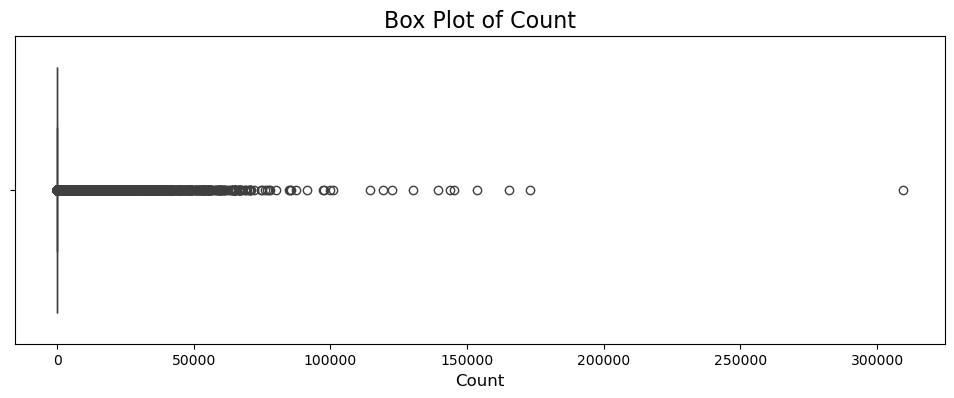

In [21]:
# destribution of count
plt.figure(figsize=(12, 4))
sns.boxplot(data=count_pd, x=count_pd['count'])
plt.title(f"Box Plot of Count", fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.show()

# Proportion of referals analysis

In [24]:
regex = r'([a-zA-Z0-9-]+)\.[a-zA-Z]{2,}$'

# Add a new column with the extracted company name
df_p = df.withColumn("company_name", regexp_extract(col("from"), regex, 1))

In [25]:
df_p = df_p.select('from', 'to', 'count', 'company_name')

In [84]:
df_p.show()

+--------------------+--------------------+-----+-------------------+
|                from|                  to|count|       company_name|
+--------------------+--------------------+-----+-------------------+
|          theybf.com|     w.sharethis.com|    1|             theybf|
|      Direct traffic|           agohq.org|    1|                   |
| twistysdownload.com|adserving.cpxinte...|    3|    twistysdownload|
|   459.cim.meebo.com|   459.cim.meebo.com|    1|              meebo|
|      boards.nbc.com| change.menelgame.pl|    1|                nbc|
|mail3-12.sinamail...|mail3-12.sinamail...|    1|                com|
|       mediafire.com|  tag.contextweb.com|    3|          mediafire|
|    mp3.rhapsody.com|         adready.com|    2|           rhapsody|
|artikel-kesehatan...|     adsensecamp.com|    4|           blogspot|
|      Direct traffic|         mlbland.com|    1|                   |
|shortlonghairstyl...|   c.statcounter.com|    1|shortlonghairstyles|
|      Direct traffi

In [26]:
# search engines
companies = ["google", "yahoo", "msn", "altavista", "ask"] ## got the names from RP
# Filter and count
df_p.filter(col("company_name").isin(companies)).count()

1998798

In [27]:
print(f"Proportion of search engine referals = {199879800/22133652}%")

Proportion of search engine referals = 9.03058383677488%


In [28]:
# Direct trafffic
df_p.filter(col('from')=='Direct traffic').count()

3058188

In [29]:
print(f"Proportion of Direct referals = {305818800/22133652}%")

Proportion of Direct referals = 13.816915527541502%


In [30]:
# Social Media
social_media = ['hi5', 'tweeter', 'friendster', 'facebook', 'myspace', 'reddit']
df_p.filter(col("company_name").isin(social_media)).count()

2361468

In [31]:
print(f"Proportion of Social Network referals = {236146800/22133652}%")

Proportion of Social Network referals = 10.669129522773739%


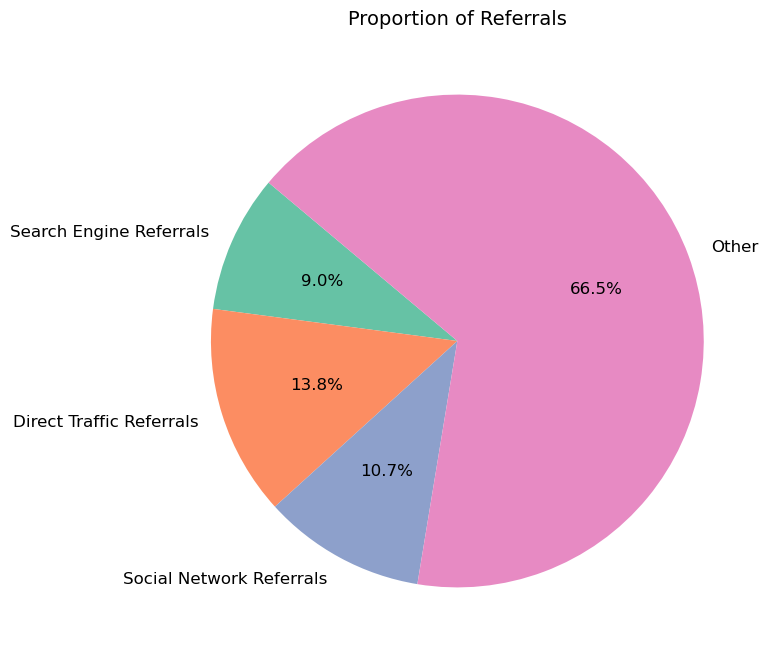

In [32]:
# Data for the pie chart
labels = ["Search Engine Referrals", "Direct Traffic Referrals", "Social Network Referrals", "Other"]
clicks = [1998798, 3058188, 2361468, 22133652 - (1998798 + 3058188 + 2361468)]
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(clicks, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12})
plt.title("Proportion of Referrals", fontsize=14)
plt.show()

In [31]:
# top referrals
result_df = (
    df.groupBy('from')
    .agg(sum('count').alias('total_referrals'))
    .orderBy('total_referrals', ascending=False)
)
# Collect to Pandas for visualization
pandas_df = result_df.limit(10).toPandas()

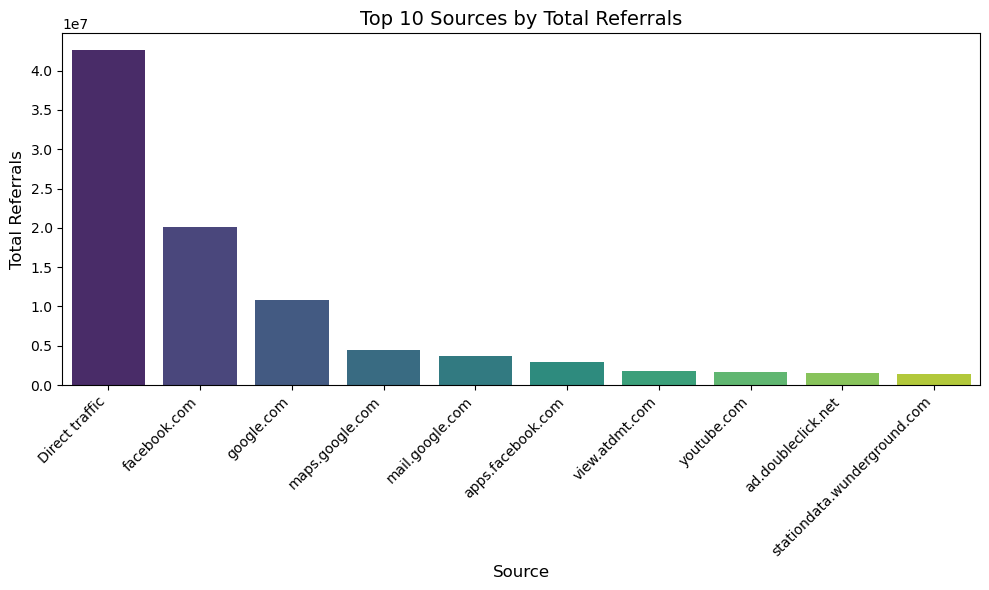

In [38]:
# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='from', y='total_referrals', data=pandas_df, palette='viridis')
plt.xlabel('Source', fontsize=12)
plt.ylabel('Total Referrals', fontsize=12)
plt.title('Top 10 Sources by Total Referrals', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# top destinations
result_df = (
    df.groupBy('to')
    .agg(sum('count').alias('total_referrals'))
    .orderBy('total_referrals', ascending=False)
)
# Collect to Pandas for visualization
pandas_df = result_df.limit(10).toPandas()

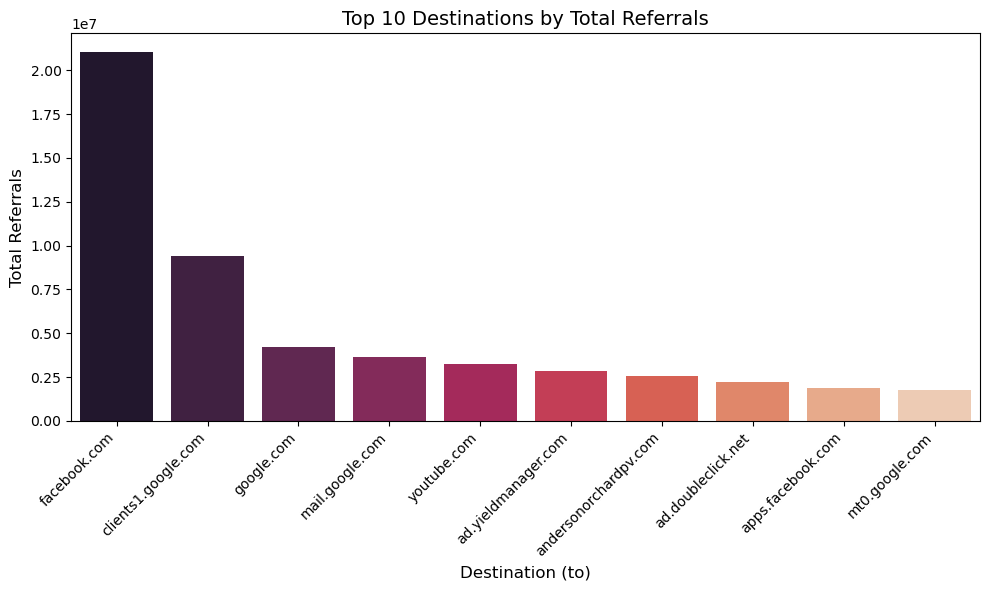

In [19]:
# Bar chart with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='to', y='total_referrals', data=pandas_df, palette='rocket')
plt.xlabel('Destination (to)', fontsize=12)
plt.ylabel('Total Referrals', fontsize=12)
plt.title('Top 10 Destinations by Total Referrals', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the chart
plt.show()


In [39]:
# df.groupBy('from').agg(sum('count').alias('total_referrals')).orderBy('total_referrals', ascending=False).show(10)

In [49]:
# df.groupBy('to').agg(sum('count').alias('total_referrals')).orderBy('total_referrals', ascending=False).show(10)

In [ ]:
#filter the top destinations for direct traffic
filtered_df = (
    df.filter(col('from') == "Direct traffic")
    .groupBy('to').agg(sum('count')
    .alias('total_referrals'))
    .orderBy('total_referrals', ascending=False)
)

# Collect top 10 to Pandas
pandas_df = filtered_df.limit(10).toPandas()

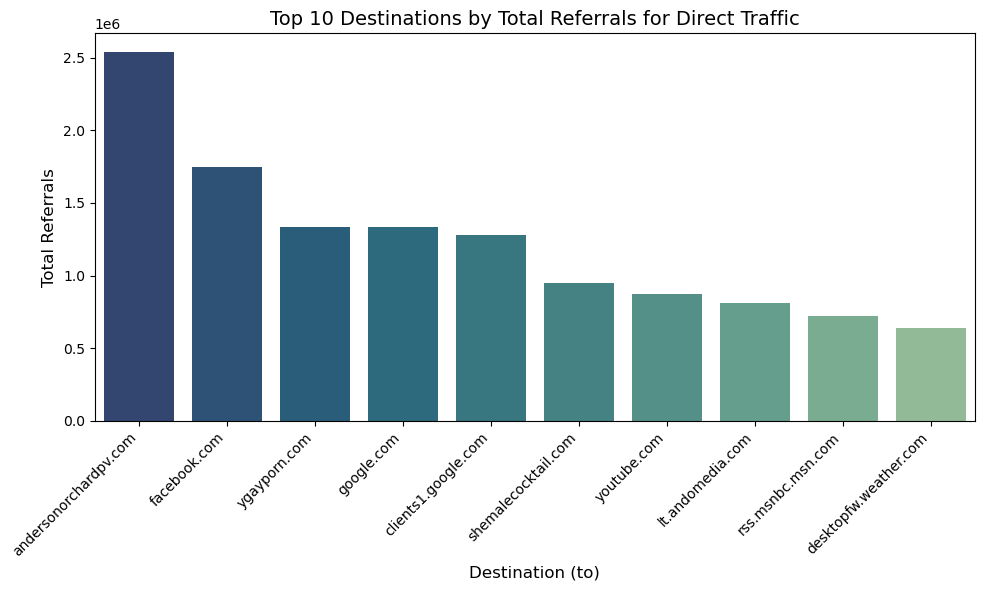

In [74]:
# Bar chart with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='to', y='total_referrals', data=pandas_df, palette='crest_r')
plt.xlabel('Destination (to)', fontsize=12)
plt.ylabel('Total Referrals', fontsize=12)
plt.title('Top 10 Destinations by Total Referrals for Direct Traffic', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Hourly Traffic Analysis

In [36]:
# date-hourly traffic  
hourly_traffic = df.groupBy("date_time").agg(_sum("count").alias("total_count"))

In [37]:
# order by date
hourly_traffic = hourly_traffic.orderBy("date_time")

In [38]:
# convert into pandas
hourly_traffic_pd = hourly_traffic.orderBy("date_time").toPandas()

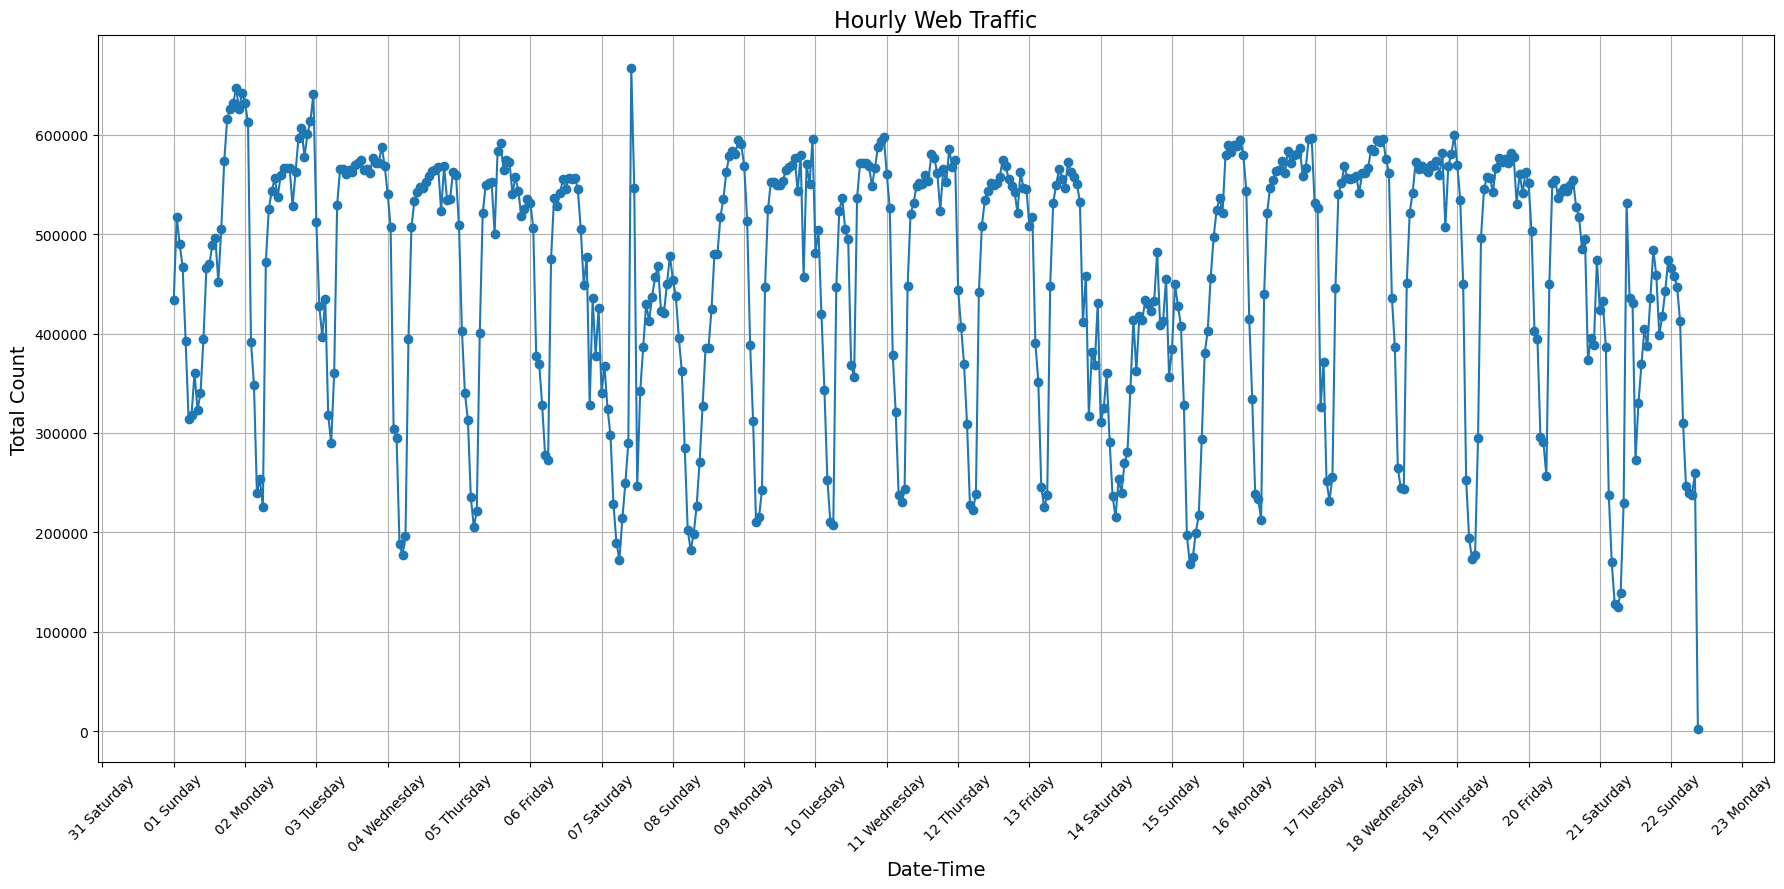

In [39]:
# Plot the line chart
plt.figure(figsize=(18, 9))
plt.plot(hourly_traffic_pd["date_time"], hourly_traffic_pd["total_count"], marker="o", linestyle="-")
plt.title("Hourly Web Traffic", fontsize=16)
plt.xlabel("Date-Time", fontsize=14)
plt.ylabel("Total Count", fontsize=14)

# Format x-axis to show both date and time
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H"))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=24))  # Set tick interval to 2 hours
# Format x-axis to show day names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %A"))

# Set tick intervals for better readability (e.g., every 24 hours)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


- We can observe common patterns in daily clicks.
- Weekdays have usual traffic between 200000 to 600000 clicks.
- Weekends have a lesser number of clicks than weekdays.
- There are a few irregularities, let's examine them

## There's a spike on saturday, let's see what's going on

In [40]:
# traffic at 7th nov
traffic_nov7 = df.filter(df["date"] == "2009-11-07")

In [41]:
# group them with hours
nov7_hourly_traffic = traffic_nov7.groupBy("time_h").agg(_sum("count").alias("total_count"))

In [42]:
# oorderby time
nov7_hourly_traffic =nov7_hourly_traffic.orderBy("time_h")

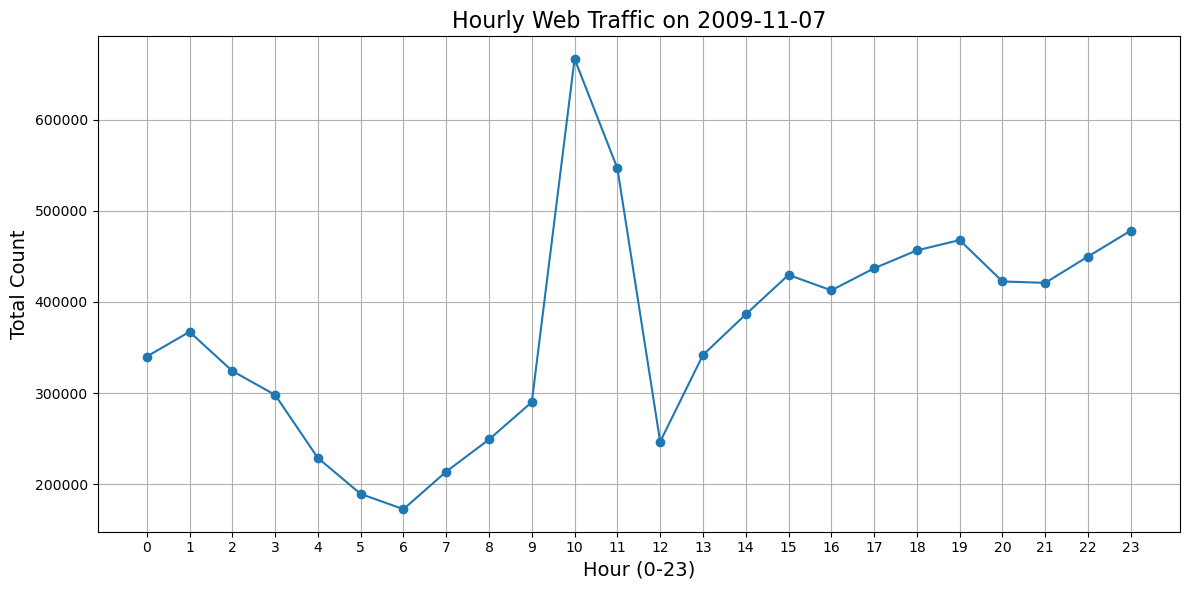

In [43]:
nov7_hourly_traffic_pd = nov7_hourly_traffic.toPandas()

# Plot hourly traffic for November 7th
plt.figure(figsize=(12, 6))
plt.plot(nov7_hourly_traffic_pd["time_h"], nov7_hourly_traffic_pd["total_count"], marker="o", linestyle="-")
plt.title("Hourly Web Traffic on 2009-11-07", fontsize=16)
plt.xlabel("Hour (0-23)", fontsize=14)
plt.ylabel("Total Count", fontsize=14)
plt.xticks(range(24))  # Set x-axis ticks for each hour
plt.grid(True)
plt.tight_layout()
plt.show()


- There's a spike on 10 AM

In [44]:
# top Referrers at 10:00 Nov 7
nov7_from = traffic_nov7.filter(traffic_nov7["time_h"] == 10) \
    .groupBy("from") \
    .agg(_sum("count").alias("total_count")) \
    .orderBy("total_count", ascending=False) \
    .limit(5) \
    .toPandas()

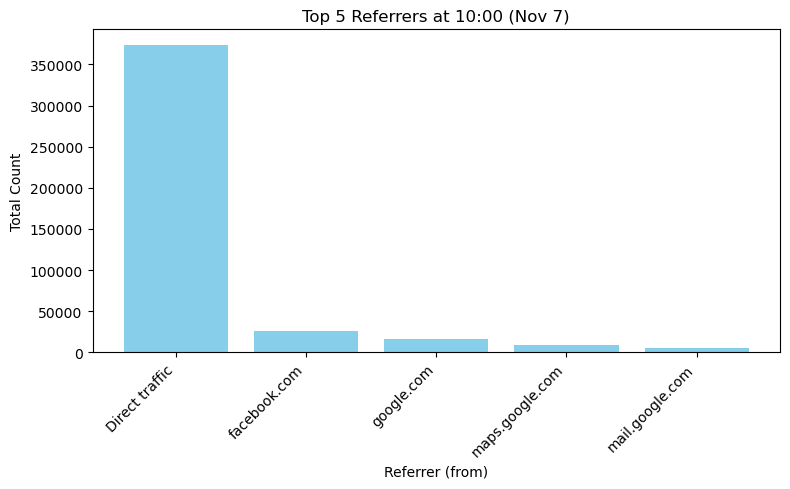

In [45]:
# barchart Top 5 Referrers at 10:00 Nov 7
plt.figure(figsize=(8, 5))
plt.bar(nov7_from["from"], nov7_from["total_count"], color="skyblue")
plt.title("Top 5 Referrers at 10:00 (Nov 7)", fontsize=12)
plt.xlabel("Referrer (from)", fontsize=10)
plt.ylabel("Total Count", fontsize=10)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [46]:
# Destination and traffic at 10:00
nov7_to = traffic_nov7.filter(traffic_nov7["time_h"] == 10) \
    .groupBy("to") \
    .agg(_sum("count").alias("total_count")) \
    .orderBy("total_count", ascending=False) \
    .limit(5).toPandas()

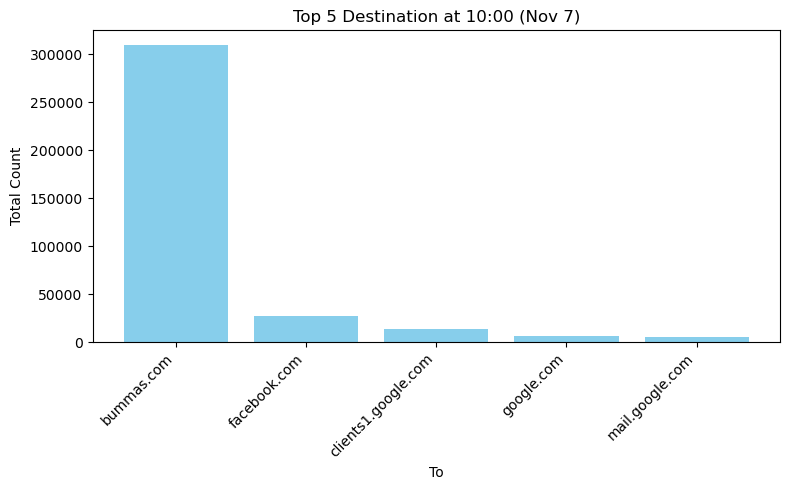

In [47]:
# barchart Top 5 Destination at 10:00
plt.figure(figsize=(8, 5))
plt.bar(nov7_to["to"], nov7_to["total_count"], color="skyblue")
plt.title("Top 5 Destination at 10:00 (Nov 7)", fontsize=12)
plt.xlabel("To", fontsize=10)
plt.ylabel("Total Count", fontsize=10)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

- Most of the traffic is going to bummas.com. This can be a potential bot.

# Direct traffic analysis

In [28]:
# direct traffic
ditect_traf_df = df.filter(df['from'] == "Direct traffic")

In [29]:
# ordered by count
ditect_traf_df.orderBy('count', ascending=False).show(10, truncate = False)

+------+--------------+----------+---------------------+-------------------+----------+------+--------+
|count |from          |timestamp |to                   |date_time          |date      |time_h|weekday |
+------+--------------+----------+---------------------+-------------------+----------+------+--------+
|309333|Direct traffic|1257588000|bummas.com           |2009-11-07 10:00:00|2009-11-07|10    |Saturday|
|165218|Direct traffic|1257591602|bummas.com           |2009-11-07 11:00:02|2009-11-07|11    |Saturday|
|153477|Direct traffic|1257058802|andersonorchardpv.com|2009-11-01 07:00:02|2009-11-01|7     |Sunday  |
|145360|Direct traffic|1257055201|andersonorchardpv.com|2009-11-01 06:00:01|2009-11-01|6     |Sunday  |
|143756|Direct traffic|1257048000|andersonorchardpv.com|2009-11-01 04:00:00|2009-11-01|4     |Sunday  |
|139425|Direct traffic|1257044401|andersonorchardpv.com|2009-11-01 03:00:01|2009-11-01|3     |Sunday  |
|130126|Direct traffic|1257051600|andersonorchardpv.com|2009-11-

### Let's compare them with normal data

In [36]:
df.orderBy('count', ascending=False).show(truncate = False)

+------+----------------------+----------+----------------------+-------------------+----------+------+--------+
|count |from                  |timestamp |to                    |date_time          |date      |time_h|weekday |
+------+----------------------+----------+----------------------+-------------------+----------+------+--------+
|309333|Direct traffic        |1257588000|bummas.com            |2009-11-07 10:00:00|2009-11-07|10    |Saturday|
|172851|indianapublicmedia.org|1258794000|indianapublicmedia.org|2009-11-21 09:00:00|2009-11-21|9     |Saturday|
|165218|Direct traffic        |1257591602|bummas.com            |2009-11-07 11:00:02|2009-11-07|11    |Saturday|
|153477|Direct traffic        |1257058802|andersonorchardpv.com |2009-11-01 07:00:02|2009-11-01|7     |Sunday  |
|145360|Direct traffic        |1257055201|andersonorchardpv.com |2009-11-01 06:00:01|2009-11-01|6     |Sunday  |
|143756|Direct traffic        |1257048000|andersonorchardpv.com |2009-11-01 04:00:00|2009-11-01|

- Most of the high traffic is coming from either Facebook or directly.
- The most amount of clicks Facebook had was 101K in an hour.
- Bummas.com had the highest clicks in one hour in the dataset.
- The users are visiting andersonorchardpv.com directly where most of the number of clicks were higher than 100K.
- Surprisingly people are visiting andersonorchardpv.com  only on Nov 1st.
- There's also indianapublicmedia.org has also huge amount of click count on Nov 22nd.

In [35]:
# Let's see normal number of clicks on facebook
df.filter(col('from')=='facebook.com').orderBy('count', ascending=False).show(truncate = False)

+------+------------+----------+------------+-------------------+----------+------+---------+
|count |from        |timestamp |to          |date_time          |date      |time_h|weekday  |
+------+------------+----------+------------+-------------------+----------+------+---------+
|101045|facebook.com|1257109201|facebook.com|2009-11-01 21:00:01|2009-11-01|21    |Sunday   |
|99764 |facebook.com|1257116401|facebook.com|2009-11-01 23:00:01|2009-11-01|23    |Sunday   |
|97534 |facebook.com|1257112801|facebook.com|2009-11-01 22:00:01|2009-11-01|22    |Sunday   |
|97342 |facebook.com|1257105600|facebook.com|2009-11-01 20:00:00|2009-11-01|20    |Sunday   |
|91384 |facebook.com|1257102000|facebook.com|2009-11-01 19:00:00|2009-11-01|19    |Sunday   |
|87298 |facebook.com|1257120000|facebook.com|2009-11-02 00:00:00|2009-11-02|0     |Monday   |
|85472 |facebook.com|1257202801|facebook.com|2009-11-02 23:00:01|2009-11-02|23    |Monday   |
|84736 |facebook.com|1257098401|facebook.com|2009-11-01 18:0

# DDoS attack detection

- Let's calculate request rate

In [11]:
# Create a window partitioned by hour
hour_window = Window.partitionBy('date_time')

# Calculate request rate
df = df.withColumn('request_rate', 
   col('count') / _sum('count').over(hour_window)
)

In [14]:
# df_w_anomaly = spark.createDataFrame(aggregated_data_pd)

In [49]:
df.show()

+-----+--------------------+----------+--------------------+-------------------+----------+------+-------+--------------------+
|count|                from| timestamp|                  to|          date_time|      date|time_h|weekday|        request_rate|
+-----+--------------------+----------+--------------------+-------------------+----------+------+-------+--------------------+
|    4|   459.cim.meebo.com|1257210000|   459.cim.meebo.com|2009-11-03 01:00:00|2009-11-03|     1|Tuesday|9.358016661948667E-6|
|   19|      boards.nbc.com|1257210000| change.menelgame.pl|2009-11-03 01:00:00|2009-11-03|     1|Tuesday|4.445057914425617E-5|
|   46|           dlist.com|1257210000|           dlist.com|2009-11-03 01:00:00|2009-11-03|     1|Tuesday|1.076171916124096...|
|    1|       mediafire.com|1257210000|  tag.contextweb.com|2009-11-03 01:00:00|2009-11-03|     1|Tuesday|2.339504165487166...|
|    1| worldbestsearch.com|1257210000|      206.161.121.90|2009-11-03 01:00:00|2009-11-03|     1|Tuesda

In [12]:
# one-hot encoding
df2 = df.withColumn("is_monday", when(col("weekday") == "Monday", 1).otherwise(0)) \
               .withColumn("is_tuesday", when(col("weekday") == "Tuesday", 1).otherwise(0)) \
               .withColumn("is_wednesday", when(col("weekday") == "Wednesday", 1).otherwise(0)) \
               .withColumn("is_thursday", when(col("weekday") == "Thursday", 1).otherwise(0)) \
               .withColumn("is_friday", when(col("weekday") == "Friday", 1).otherwise(0)) \
               .withColumn("is_saturday", when(col("weekday") == "Saturday", 1).otherwise(0))

In [13]:
df2.show()

+-----+--------------------+----------+--------------------+-------------------+----------+------+-------+--------------------+---------+----------+------------+-----------+---------+-----------+
|count|                from| timestamp|                  to|          date_time|      date|time_h|weekday|        request_rate|is_monday|is_tuesday|is_wednesday|is_thursday|is_friday|is_saturday|
+-----+--------------------+----------+--------------------+-------------------+----------+------+-------+--------------------+---------+----------+------------+-----------+---------+-----------+
|    4|   459.cim.meebo.com|1257210000|   459.cim.meebo.com|2009-11-03 01:00:00|2009-11-03|     1|Tuesday|9.358016661948667E-6|        0|         1|           0|          0|        0|          0|
|   19|      boards.nbc.com|1257210000| change.menelgame.pl|2009-11-03 01:00:00|2009-11-03|     1|Tuesday|4.445057914425617E-5|        0|         1|           0|          0|        0|          0|
|   46|           dl

In [51]:
#converting into pandas
df_pd = df2.select('count', 'from', 'to', 'date', 'time_h', 'request_rate', 'is_monday','is_tuesday','is_wednesday','is_thursday','is_friday','is_saturday').toPandas()

# Isolation Forest for Aaomaly Detection

In [52]:
# all the features for isolation forest
features = df_pd[['time_h','is_monday','is_tuesday','is_wednesday','is_thursday','is_friday','is_saturday','count','request_rate']]

In [53]:
# Train Isolation Forest
start=time.time()
iso_forest = IsolationForest(contamination=0.001, n_estimators=150, n_jobs=-1)
iso_forest.fit(features)
end=time.time()
print(end-start)

84.14925980567932


In [54]:
# Predict anomalies
start=time.time()
df_pd['anomaly'] = iso_forest.predict(features)
df_pd['anomaly'] = df_pd['anomaly'].apply(lambda x: 1 if x == -1 else 0)
end=time.time()
print(end-start)

82.65706443786621


In [55]:
# all the rows with anomaly
df_pd[df_pd['anomaly'] == 1]

,count,from,to,date,time_h,request_rate,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday,is_saturday,anomaly
129,638,0.channel43.facebook.com,0.channel43.facebook.com,2009-11-03,1,0.001493,0,1,0,0,0,0,1
543,1085,0.channel23.facebook.com,0.channel23.facebook.com,2009-11-03,1,0.002538,0,1,0,0,0,0,1
1212,2857,stationdata.wunderground.com,stationdata.wunderground.com,2009-11-03,1,0.006684,0,1,0,0,0,0,1
1255,1037,Direct traffic,video.od.visiblemeasures.com,2009-11-03,1,0.002426,0,1,0,0,0,0,1
1757,684,0.channel22.facebook.com,0.channel22.facebook.com,2009-11-03,1,0.001600,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22132131,1501,maps.google.com,mt0.google.com,2009-11-12,5,0.006749,0,0,0,1,0,0,1
22132552,6570,facebook.com,facebook.com,2009-11-12,5,0.029541,0,0,0,1,0,0,1
22132773,694,Direct traffic,broadcaster.alumni.iu.edu,2009-11-12,5,0.003120,0,0,0,1,0,0,1
22133075,707,facebook.com,platform.ak.fbcdn.net,2009-11-12,5,0.003179,0,0,0,1,0,0,1


- 22113 anomalies (0.001% of 22million)

In [56]:
# combining date, time
df_pd['date_time'] = pd.to_datetime(df_pd['date']) + pd.to_timedelta(df_pd['time_h'], unit='h')

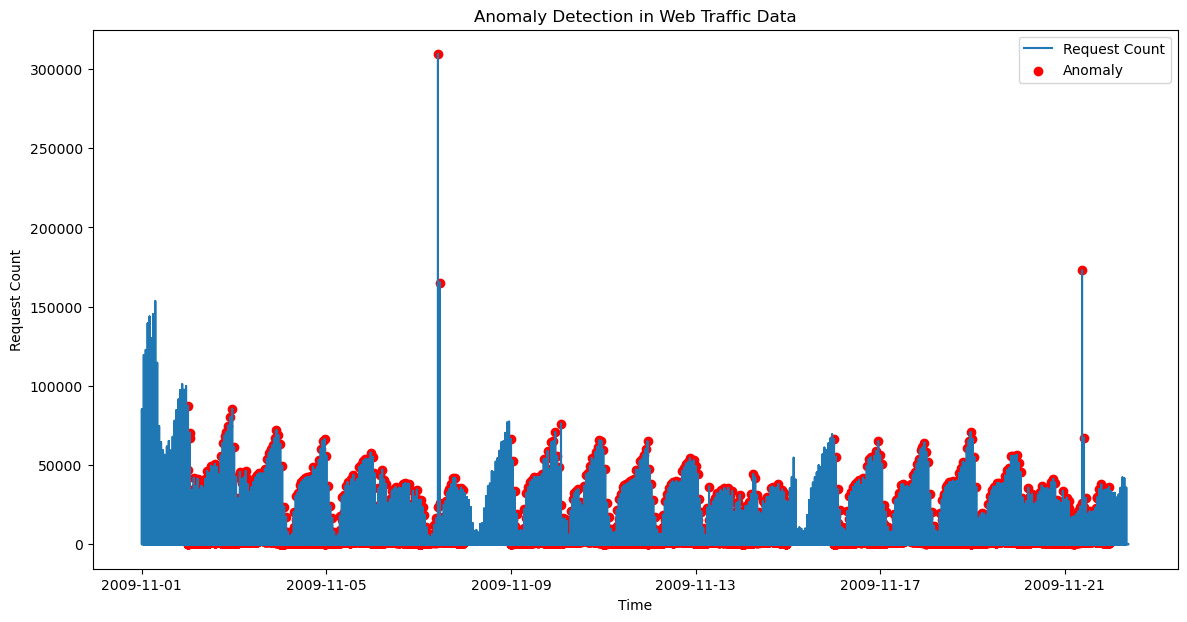

In [57]:
## Anomaly detection chart
plt.figure(figsize=(14, 7))
plt.plot(df_pd['date_time'], df_pd['count'], label='Request Count')
plt.scatter(df_pd[df_pd['anomaly'] == 1]['date_time'], 
            df_pd[df_pd['anomaly'] == 1]['count'], 
            color='red', label='Anomaly')
plt.xlabel('Time')
plt.ylabel('Request Count')
plt.title('Anomaly Detection in Web Traffic Data')
plt.legend()
plt.show()

In [59]:
# drop date_time
df_pd.drop('date_time', axis=1, inplace=True)

In [60]:
# convert it back into pyspark dataframe
df_w_anomaly = spark.createDataFrame(df_pd)

In [61]:
# combining anomaly column with main data
df_anomaly = df.join(
    df_w_anomaly.select('from', 'to', 'date', 'time_h', 'anomaly'),
    on=['from', 'to', 'date', 'time_h'],
    how='left'
)

In [25]:
df_anomaly

DataFrame[from: string, to: string, date: date, time_h: int, count: bigint, timestamp: bigint, date_time: timestamp, weekday: string, request_rate: double, anomaly: bigint]

In [62]:
# summary of the data 
df_anomaly.select('time_h', 'count', 'request_rate', 'anomaly').summary().show() 

[2673.078s][warning][gc,alloc] Executor task launch worker for task 3.0 in stage 75.0 (TID 3430): Retried waiting for GCLocker too often allocating 256 words


+-------+------------------+-----------------+--------------------+--------------------+
|summary|            time_h|            count|        request_rate|             anomaly|
+-------+------------------+-----------------+--------------------+--------------------+
|  count|          22133652|         22133652|            22133652|            22133652|
|   mean|12.613740561205173|10.64005253177379|2.322255721739984...|9.990669411446425E-4|
| stddev| 6.503470748769002|264.1118775081526|5.606596250315108E-4|0.031592227706899345|
|    min|                 0|                1|1.499835018148003...|                   0|
|    25%|                 8|                1|1.820144264634415E-6|                   0|
|    50%|                13|                1|3.398886524774483...|                   0|
|    75%|                18|                4|7.419828750352442E-6|                   0|
|    max|                23|           309333| 0.46394846566877646|                   1|
+-------+------------

In [63]:
# anomalies which are not facebook.com
df_anomaly.filter((col('anomaly') == 1) & (col('to') != 'facebook.com')) \
    .select('from', 'to','count') \
    .orderBy('count', ascending=False) \
    .show()

+--------------------+--------------------+------+
|                from|                  to| count|
+--------------------+--------------------+------+
|      Direct traffic|          bummas.com|309333|
|indianapublicmedi...|indianapublicmedi...|172851|
|      Direct traffic|          bummas.com|165218|
|      Direct traffic|    joycemaynard.com| 76162|
|      Direct traffic|andersonorchardpv...| 70388|
|indianapublicmedi...|indianapublicmedi...| 67200|
|      Direct traffic| shemalecocktail.com| 47079|
|      Direct traffic|andersonorchardpv...| 46934|
|      Direct traffic|andersonorchardpv...| 46268|
|      Direct traffic|andersonorchardpv...| 45640|
|      Direct traffic| shemalecocktail.com| 44183|
|      Direct traffic| shemalecocktail.com| 43606|
|      Direct traffic|   quitesensible.com| 42474|
|      Direct traffic| shemalecocktail.com| 42080|
|      Direct traffic|andersonorchardpv...| 42070|
|      Direct traffic|andersonorchardpv...| 41917|
|      Direct traffic|   quites

In [64]:
# total unique destinations that are anomalies
df_anomaly.filter((col('anomaly') == 1)) \
    .select('to') \
    .dropDuplicates(['to']) \
    .orderBy('count', ascending=False) \
    .count()

621

In [65]:
# distribution of anomaly flags 
box_plt = df_anomaly.filter(col('anomaly')==1).select('count').toPandas()

In [66]:
# shape of data with anomaly 
box_plt.shape

(22113, 1)

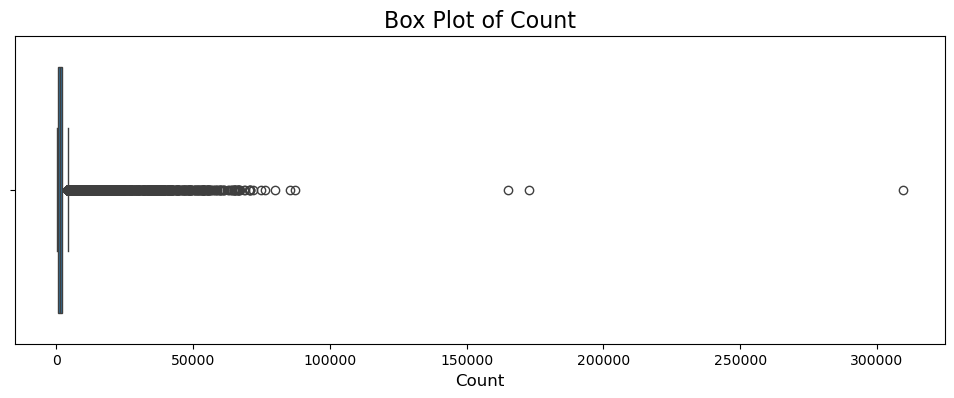

In [67]:
# boxplot of count with anomaly flag
plt.figure(figsize=(12, 4))
sns.boxplot(data=box_plt, x=box_plt['count'])
plt.title(f"Box Plot of Count", fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.show()

- As we can observe, Anomalies ranges from 0 to 300000. These can not be DDoS atteck.
- Therefore, Isolation forest is not ideal for this.

# KMeans Cluster

In [14]:
df2

DataFrame[count: bigint, from: string, timestamp: bigint, to: string, date_time: timestamp, date: date, time_h: int, weekday: string, request_rate: double, is_monday: int, is_tuesday: int, is_wednesday: int, is_thursday: int, is_friday: int, is_saturday: int]

In [24]:
# features
feature_columns = ['count', 'request_rate','time_h','is_monday', 'is_tuesday', 'is_wednesday',
                   'is_thursday', 'is_friday', 'is_saturday']

In [97]:
# # Filter for high-traffic data points
# high_traffic_df = df2.filter(col('count') >1000)

In [25]:
# Vector assembler
assembler = VectorAssembler(
        inputCols=feature_columns, 
        outputCol="features_raw"
    )

In [26]:
# Standardize features
scaler = StandardScaler(
    inputCol="features_raw", 
    outputCol="features",
    withStd=True,
    withMean=True
)

In [27]:
# Prepare data
assembled_df = assembler.transform(df2)
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

### Let's try different number of clusters

In [28]:
def high_traffic_clustering(df, min_count=0, min_clusters = 2, max_clusters=10):

    # Filter for high-traffic data points
    high_traffic_df = df.filter(col('count') > min_count)
    
    # Determine optimal number of clusters (simple method)
    cluster_sizes = []
    cluster_summaries = []

    # min(max_clusters + 1, len(feature_columns))
    # Try different cluster numbers
    for k in range(min_clusters, max_clusters):
        # K-Means Clustering
        kmeans = KMeans(k=k, featuresCol="features", predictionCol="cluster")
        model = kmeans.fit(scaled_df)
        
        # Add cluster predictions
        clustered_df = model.transform(scaled_df)
        
        # Analyze cluster characteristics
        cluster_summary = clustered_df.groupBy("cluster").agg(
            mean("count").alias("avg_count"),
            mean("request_rate").alias("avg_request_rate"),
            mean("time_h").alias("avg_hour"),
            count("*").alias("cluster_size")
        ).orderBy("avg_count", ascending=False)
        
        cluster_sizes.append((k, cluster_summary))
        cluster_summaries.append(cluster_summary)
    
    # Return detailed cluster information
    return cluster_sizes


In [29]:
# 7 to 14 clusters
cluster_results = high_traffic_clustering(df2, min_clusters=7, max_clusters=15)

In [30]:
# summary
for k, summary in cluster_results:
    print(f"\nClustering with {k} clusters:")
    summary.show()


Clustering with 7 clusters:


+-------+-----------------+--------------------+------------------+------------+
|cluster|        avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+-----------------+--------------------+------------------+------------+
|      6|133623.0588235294|  0.2897734851823132| 9.470588235294118|          17|
|      3|33270.18791946309| 0.06953296224659453|12.135570469798658|         745|
|      4| 9.80894412456268| 2.31189882840311E-5| 12.68765124886697|     8533535|
|      5|9.588222127502007|2.087565236993545E-5|12.106025921718112|     3127339|
|      0|   9.095164144771|1.822049257041625...| 12.73475338062577|     3505564|
|      2| 9.02529372272099|1.855300185806450...| 12.70575468963037|     3528583|
|      1|9.024361021318729|1.901205270252706E-5|12.674414295599977|     3437869|
+-------+-----------------+--------------------+------------------+------------+


Clustering with 8 clusters:


+-------+------------------+--------------------+------------------+------------+
|cluster|         avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+------------------+--------------------+------------------+------------+
|      6|37649.774668630336|  0.0790821952763325|11.829160530191459|         679|
|      1|10.192654691926055|2.346836166547267...| 6.448053256295567|     1404679|
|      4| 9.863561710619823|2.316646937823120...|12.658272090759764|     8582129|
|      5| 9.743600443184597|2.117259884726528...|12.106026639039575|     3127365|
|      7| 9.649669386392203|2.413195711803462E-5| 6.427978553183525|     1410559|
|      0| 9.052148054689297|1.860147471784002...|12.705762758361136|     3528588|
|      3| 8.672127080148709|1.561030525892212...| 17.02054338759712|     2027319|
|      2| 8.461373246264984|1.509600441235138...| 17.16156483301451|     2052334|
+-------+------------------+--------------------+------------------+------------+


Clustering wit

+-------+------------------+--------------------+------------------+------------+
|cluster|         avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+------------------+--------------------+------------------+------------+
|      3|37649.774668630336|  0.0790821952763325|11.829160530191459|         679|
|      4| 11.51303568988312|2.636573280938379E-5|  5.59995867435225|     1214742|
|      6|10.192654691926055|2.346836166547267...| 6.448053256295567|     1404679|
|      7|10.048951012519082|2.812992617728360...|12.827840931784989|     2303364|
|      8| 9.795551672980276| 2.13456259947808E-5|12.596065786822727|     6278765|
|      1|   9.0732120220671|1.910673320800534...|12.674421256368028|     3437878|
|      0| 9.052148054689297|1.860147471784002...|12.705762758361136|     3528588|
|      5| 8.619799615501853|1.787434407598399E-5|16.238149912450076|     1912623|
|      2| 8.461373246264984|1.509600441235138...| 17.16156483301451|     2052334|
+-------+-------

+-------+------------------+--------------------+------------------+------------+
|cluster|         avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+------------------+--------------------+------------------+------------+
|      3|37649.774668630336|  0.0790821952763325|11.829160530191459|         679|
|      4|10.632886123365333|2.520891218063881...|12.420746258646167|     2773194|
|      7|  10.5163854078763|3.489900021169547...| 6.258973831964095|     1011998|
|      6|10.192654691926055|2.346836166547267...| 6.448053256295567|     1404679|
|      5| 9.743600443184597|2.117259884726528...|12.106026639039575|     3127365|
|      9|   9.6826391588442|2.282524153739384E-5|17.975630456431407|     1291366|
|      8| 9.133151489443517|1.828944996213962...|12.734757903919219|     3505571|
|      1|   9.0732120220671|1.910673320800534...|12.674421256368028|     3437878|
|      0| 9.052148054689297|1.860147471784002...|12.705762758361136|     3528588|
|      2| 8.4613

+-------+------------------+--------------------+------------------+------------+
|cluster|         avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+------------------+--------------------+------------------+------------+
|      6|156014.63636363635|  0.3535125648388972|               6.0|          11|
|      8|43897.528436018954| 0.09072084350464543|12.495260663507109|         422|
|      9|12933.113374667848| 0.02981442533530662| 10.70770593445527|        1129|
|      1| 10.17276888408233|2.390812393701616...|12.420896315734623|     2773063|
|      3| 9.511353339617227|2.663531173044989E-5|12.827865318596432|     2303243|
|      5| 9.175333435874052|1.994403518648578...|12.106055455768443|     3127213|
|      7| 9.160097697930476|2.290972214623569...|  6.42787297851071|     1410470|
|      4| 8.784184089379863|1.762952238063661...|12.808510028968268|     3456886|
|     10| 8.781270842521396|1.750677711323652...|  12.7348169452516|     3505454|
|      0|  8.705

+-------+------------------+--------------------+------------------+------------+
|cluster|         avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+------------------+--------------------+------------------+------------+
|      6|156014.63636363635|  0.3535125648388972|               6.0|          11|
|      8|43897.528436018954| 0.09072084350464543|12.495260663507109|         422|
|      9|12928.400884955752|0.029799306683265137| 10.71858407079646|        1130|
|     11| 10.17276888408233|2.390812393701616...|12.420896315734623|     2773063|
|      4| 9.511353339617227|2.663531173044989E-5|12.827865318596432|     2303243|
|      5| 9.175333435874052|1.994403518648578...|12.106055455768443|     3127213|
|      7| 9.160097697930476|2.290972214623569...|  6.42787297851071|     1410470|
|      1| 9.069946105146949|2.059508521829877...| 7.086178203996398|     1586979|
|     10| 8.781270842521396|1.750677711323652...|  12.7348169452516|     3505454|
|      0|  8.705

+-------+------------------+--------------------+------------------+------------+
|cluster|         avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+------------------+--------------------+------------------+------------+
|      1|156014.63636363635|  0.3535125648388972|               6.0|          11|
|      8|43897.528436018954| 0.09072084350464543|12.495260663507109|         422|
|      9|12928.400884955752|0.029799306683265137| 10.71858407079646|        1130|
|      2|10.937009477377053|3.352854765341746E-5|  4.29730398003293|     1031298|
|     12| 9.720262492356891|1.821187688997663...|17.230870410187368|     1741765|
|     10| 9.528888468302423|2.128019688911837...| 6.948382396932146|     1574521|
|      5| 9.511353339617227|2.663531173044989E-5|12.827865318596432|     2303243|
|      7| 9.160097697930476|2.290972214623569...|  6.42787297851071|     1410470|
|      4| 8.816807840833855| 1.85890886419102E-5|17.336239254146992|     1552692|
|      6| 8.7819

+-------+------------------+--------------------+------------------+------------+
|cluster|         avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+------------------+--------------------+------------------+------------+
|      7|          309333.0| 0.46394846566877646|              10.0|           1|
|     10|          118322.5| 0.26608553404138463| 9.555555555555555|          18|
|      5| 33024.71122994652| 0.06904535023559974|12.168449197860962|         748|
|      4|12.475978150141202|3.798751762979844E-5|3.2638609461620036|      861882|
|      2|10.574338312110575|1.787889791104178...|19.987815497013038|      988797|
|     13| 9.995807178476257|2.235193109683525...|6.9483670732048095|     1574596|
|      6| 9.989680704884831|2.797233208040933...| 12.82783765420441|     2303355|
|      8|  9.63988529922134|2.199483331715273E-5| 7.086178694790326|     1587086|
|      9|  9.17490080457616|1.937859678619657...|17.336272647823883|     1552743|
|     11| 9.0603

#### 11 clusters would work perfectly

In [31]:
# fit the data and form 11 clusters
kmeans = KMeans(k=11, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(scaled_df)

In [32]:
# form the clusters
clustered_df = model.transform(scaled_df)

In [33]:
clustered_df

DataFrame[count: bigint, from: string, timestamp: bigint, to: string, date_time: timestamp, date: date, time_h: int, weekday: string, request_rate: double, is_monday: int, is_tuesday: int, is_wednesday: int, is_thursday: int, is_friday: int, is_saturday: int, features_raw: vector, features: vector, cluster: int]

In [34]:
# summary of the clusters
cluster_summary = clustered_df.groupBy("cluster").agg(
    mean("count").alias("avg_count"),
    mean("request_rate").alias("avg_request_rate"),
    mean("time_h").alias("avg_hour"),
    count("*").alias("cluster_size")).orderBy("avg_count", ascending=False)

In [35]:
cluster_summary.show()

+-------+------------------+--------------------+------------------+------------+
|cluster|         avg_count|    avg_request_rate|          avg_hour|cluster_size|
+-------+------------------+--------------------+------------------+------------+
|      6|156014.63636363635|  0.3535125648388972|               6.0|          11|
|      8|43897.528436018954| 0.09072084350464543|12.495260663507109|         422|
|      9|12933.113374667848| 0.02981442533530662| 10.70770593445527|        1129|
|      1| 10.17276888408233|2.390812393701616...|12.420896315734623|     2773063|
|      3| 9.511353339617227|2.663531173044989E-5|12.827865318596432|     2303243|
|      5| 9.175333435874052|1.994403518648578...|12.106055455768443|     3127213|
|      7| 9.160097697930476|2.290972214623569...|  6.42787297851071|     1410470|
|      4| 8.784184089379863|1.762952238063661...|12.808510028968268|     3456886|
|     10| 8.781270842521396|1.750677711323652...|  12.7348169452516|     3505454|
|      0|  8.705

- Clusters 6, 8, and 9 are seemed to be apropreate to lebel the data

In [45]:
# Data from cluster 6 and 8
clustered_df.filter((col('cluster')==6) | (col('cluster')==8)) \
    .select('cluster','from', 'to', 'count') \
    .orderBy('count',ascending=False).show()

+-------+--------------------+--------------------+------+
|cluster|                from|                  to| count|
+-------+--------------------+--------------------+------+
|      6|      Direct traffic|          bummas.com|309333|
|      6|indianapublicmedi...|indianapublicmedi...|172851|
|      6|      Direct traffic|          bummas.com|165218|
|      6|      Direct traffic|andersonorchardpv...|153477|
|      6|      Direct traffic|andersonorchardpv...|145360|
|      6|      Direct traffic|andersonorchardpv...|143756|
|      6|      Direct traffic|andersonorchardpv...|139425|
|      6|      Direct traffic|andersonorchardpv...|130126|
|      6|      Direct traffic|andersonorchardpv...|122681|
|      6|      Direct traffic|andersonorchardpv...|119369|
|      6|      Direct traffic|andersonorchardpv...|114565|
|      8|        facebook.com|        facebook.com|101045|
|      8|        facebook.com|        facebook.com| 99764|
|      8|        facebook.com|        facebook.com| 9753

Let's see unique potential DDoS Attecks

In [46]:
# Data from cluster 6 and 8 without duplicates
clustered_df.filter((col('cluster')==6) | (col('cluster')==8)) \
    .select('cluster','from', 'to', 'count').dropDuplicates(['to']) \
    .orderBy('count',ascending=False).show()

+-------+--------------------+--------------------+------+
|cluster|                from|                  to| count|
+-------+--------------------+--------------------+------+
|      6|      Direct traffic|          bummas.com|165218|
|      6|      Direct traffic|andersonorchardpv...|139425|
|      8|      Direct traffic|    joycemaynard.com| 76162|
|      8|indianapublicmedi...|indianapublicmedi...| 67200|
|      8|        facebook.com|        facebook.com| 42217|
|      8|      Direct traffic|             dsw.com| 40856|
|      8|      Direct traffic|   quitesensible.com| 38356|
|      8|      Direct traffic|            hcgb.net| 31969|
|      8|      Direct traffic| shemalecocktail.com| 26744|
|      8|      Direct traffic|        ygayporn.com| 18982|
|      8|         twitpic.com| beacon.videoegg.com|   233|
+-------+--------------------+--------------------+------+



Label the data into 4 categories: High Risk, Medium Risk, Low Risk, Normal

In [37]:
# lebel the data 
def add_cluster_flag(df):
    df_with_flag = df.withColumn(
        "cluster_flag", 
        when(col("cluster") == 6, lit('High Risk'))  # Cluster 6 flag 3 (highest traffic)
        .when(col("cluster") == 8, lit('Medium Risk'))  # Cluster 8 flag 2 (second highest traffic)
        .when(col("cluster") == 9, lit('Low Risk'))  # Cluster 9 flag 1
        .otherwise(lit('Normal'))  # Default flag 0
    )
    
    return df_with_flag

In [38]:
# Apply the flagging
df_flagged = add_cluster_flag(clustered_df)

In [39]:
# Verify the flag distribution
df_flagged.groupBy("cluster_flag").count().show()

+------------+--------+
|cluster_flag|   count|
+------------+--------+
|    Low Risk|    1129|
| Medium Risk|     422|
|      Normal|22132090|
|   High Risk|      11|
+------------+--------+



# Let's Do further analysis. 
### It seems that many websites like Facebook and google have high traffic but it is normal for those websites to have a huge number of clicks.

In [50]:
df_flagged

DataFrame[count: bigint, from: string, timestamp: bigint, to: string, date_time: timestamp, date: date, time_h: int, weekday: string, request_rate: double, is_monday: int, is_tuesday: int, is_wednesday: int, is_thursday: int, is_friday: int, is_saturday: int, features_raw: vector, features: vector, cluster: int, cluster_flag: string]

In [51]:
# lets analyse the name of the destinations
web_ana = df_flagged.filter((col('cluster') == 6)|(col('cluster') == 8) |(col('cluster') == 9)).select('from', 'to', 'count')

In [52]:
# get the word before .XXX
regex = r'([a-zA-Z0-9-]+)\.[a-zA-Z]{2,}$'

# Add a new column with the extracted company name
df_with_company_name = web_ana.withColumn("company_name", regexp_extract(col("to"), regex, 1))

In [53]:
# total unique company names
df_with_company_name.dropDuplicates(['to']).orderBy('count',ascending=False).count()

53

In [54]:
df_with_company_name.dropDuplicates(['to']).orderBy('count',ascending=False).show()

+--------------------+--------------------+------+------------------+
|                from|                  to| count|      company_name|
+--------------------+--------------------+------+------------------+
|      Direct traffic|          bummas.com|165218|            bummas|
|      Direct traffic|    joycemaynard.com| 76162|      joycemaynard|
|        facebook.com|        facebook.com| 42217|          facebook|
|      Direct traffic|             dsw.com| 40856|               dsw|
|      Direct traffic|            hcgb.net| 21608|              hcgb|
|           boost.org|           boost.org| 18720|             boost|
|      Direct traffic|andersonorchardpv...| 17902| andersonorchardpv|
|      Direct traffic|      dmed.iupui.edu| 17839|             iupui|
|      Direct traffic|pubchem.ncbi.nlm....| 16175|               nih|
|      Direct traffic|   quitesensible.com| 16172|     quitesensible|
|      Direct traffic|         manhunt.net| 15087|           manhunt|
|      Direct traffi

In [55]:
# flag the common contries as 0
company_list = ['google', 'amazon', 'iu', 'facebook', 'cnn', 'netflix', 
                'myspace', 'yahoo', 'youtube', 'bing', 'wikipedia', 
                'twitter', 'nytimes', 'microsoft', 'imdb']

# Add the flag column
flagged_df = df_with_company_name.withColumn(
    'flag',
    when(col('company_name').isin(company_list), 0).otherwise(1)
)

In [56]:
flagged_df.show()

+-------------------+--------------------+-----+-----------------+----+
|               from|                  to|count|     company_name|flag|
+-------------------+--------------------+-----+-----------------+----+
|         google.com| clients1.google.com| 9799|           google|   0|
|     Direct traffic|andersonorchardpv...|17902|andersonorchardpv|   1|
|       facebook.com|        facebook.com|42217|         facebook|   0|
|     Direct traffic|   quitesensible.com|16172|    quitesensible|   1|
|         google.com| clients1.google.com| 8182|           google|   0|
|       facebook.com|        facebook.com|23698|         facebook|   0|
|         google.com| clients1.google.com| 6083|           google|   0|
|  emice.nci.nih.gov|8080/emice/mouse_...| 7657|                 |   1|
|video.adultswim.com| video.adultswim.com|11041|        adultswim|   1|
|       facebook.com|        facebook.com|13267|         facebook|   0|
|         google.com| clients1.google.com|23086|           googl

In [57]:
flagged_df

DataFrame[from: string, to: string, count: bigint, company_name: string, flag: int]

In [58]:
# join them with the main dataframe
df_flagged = df_flagged.join(
    flagged_df.select("from", "to", "count", "flag"),
    on=["from", "to", "count"],  # Join condition
    how="left"  # Keep all rows from df_flagged, add flag if matched
)

In [141]:
# df_flagged = df_flagged.drop('flag')

In [59]:
# fill the null (Those with normal traffic) with 2
df_flagged = df_flagged.fillna({"flag": 2})

In [60]:
df_flagged.filter((col('cluster') == 6)|(col('cluster') == 8) |(col('cluster') == 9)) \
    .select('cluster','from', 'to', 'count','flag','cluster_flag').show()

+-------+-------------------+--------------------+-----+----+------------+
|cluster|               from|                  to|count|flag|cluster_flag|
+-------+-------------------+--------------------+-----+----+------------+
|      9|         google.com| clients1.google.com|23115|   0|    Low Risk|
|      9|     Direct traffic|andersonorchardpv...|17902|   1|    Low Risk|
|      9|  emice.nci.nih.gov|8080/emice/mouse_...| 7657|   1|    Low Risk|
|      9|    mail.google.com|     mail.google.com|10128|   0|    Low Risk|
|      9|    mail.google.com|     mail.google.com|10299|   0|    Low Risk|
|      9|     Direct traffic|   quitesensible.com|16172|   1|    Low Risk|
|      9|video.adultswim.com| video.adultswim.com|11041|   1|    Low Risk|
|      8|       facebook.com|        facebook.com|42217|   0| Medium Risk|
|      9|         google.com| clients1.google.com| 8182|   0|    Low Risk|
|      9|         google.com| clients1.google.com|23086|   0|    Low Risk|
|      9|         google.

In [61]:
df_flagged.select('flag', 'cluster_flag').show()

+----+------------+
|flag|cluster_flag|
+----+------------+
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
|   2|      Normal|
+----+------------+
only showing top 20 rows



In [62]:
# remove the risk from the websites like facebook and google
df_flagged = df_flagged.withColumn(
    "cluster_flag",
    when(col("flag") == 0, "Normal").otherwise(col("cluster_flag"))
)

In [63]:
# convert unnecessary Risk flags to normal
df_flagged = df_flagged.withColumn(
    "cluster_flag",
    when(col("count") < 2000, "Normal")  # count < 2000
    .when((col("count") >= 2000) & (col("count") < 5000) &(col("cluster_flag") != 'Normal'), "Low Risk")  # 2000 <= count < 5000
    .otherwise(col("cluster_flag"))  # Retain original value for other cases
)

In [64]:
# drop unwanted columns
df_flagged = df_flagged.drop('is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday','features_raw', 'features')

In [65]:
# final summary
df_flagged.groupBy("cluster_flag").count().show()

+------------+--------+
|cluster_flag|   count|
+------------+--------+
|    Low Risk|     296|
|      Normal|22133297|
| Medium Risk|      68|
|   High Risk|      11|
+------------+--------+



In [69]:
# high risk
df_flagged.filter(col("cluster_flag")=='High Risk').select('from', 'to', 'count').orderBy('count',ascending=False).show()

+--------------------+--------------------+------+
|                from|                  to| count|
+--------------------+--------------------+------+
|      Direct traffic|          bummas.com|309333|
|indianapublicmedi...|indianapublicmedi...|172851|
|      Direct traffic|          bummas.com|165218|
|      Direct traffic|andersonorchardpv...|153477|
|      Direct traffic|andersonorchardpv...|145360|
|      Direct traffic|andersonorchardpv...|143756|
|      Direct traffic|andersonorchardpv...|139425|
|      Direct traffic|andersonorchardpv...|130126|
|      Direct traffic|andersonorchardpv...|122681|
|      Direct traffic|andersonorchardpv...|119369|
|      Direct traffic|andersonorchardpv...|114565|
+--------------------+--------------------+------+



In [70]:
# medium risk
df_flagged.filter(col("cluster_flag")=='Medium Risk').select('from', 'to', 'count').orderBy('count',ascending=False).show()

+--------------------+--------------------+-----+
|                from|                  to|count|
+--------------------+--------------------+-----+
|      Direct traffic|andersonorchardpv...|85268|
|      Direct traffic|    joycemaynard.com|76162|
|      Direct traffic|andersonorchardpv...|74478|
|      Direct traffic|andersonorchardpv...|70388|
|indianapublicmedi...|indianapublicmedi...|67200|
|      Direct traffic|andersonorchardpv...|64328|
|      Direct traffic|andersonorchardpv...|59245|
|      Direct traffic|             dsw.com|54605|
|      Direct traffic| shemalecocktail.com|47079|
|      Direct traffic|andersonorchardpv...|46934|
|      Direct traffic|andersonorchardpv...|46268|
|      Direct traffic|andersonorchardpv...|45640|
|      Direct traffic| shemalecocktail.com|44183|
|      Direct traffic| shemalecocktail.com|43606|
|      Direct traffic|   quitesensible.com|42474|
|      Direct traffic|             dsw.com|42281|
|      Direct traffic|        ygayporn.com|42203|


In [71]:
# low risk
df_flagged.filter(col("cluster_flag")=='Low Risk').select('from', 'to', 'count').orderBy('count',ascending=False).show()

+--------------+--------------------+-----+
|          from|                  to|count|
+--------------+--------------------+-----+
|Direct traffic|andersonorchardpv...|31655|
|Direct traffic|andersonorchardpv...|28712|
|Direct traffic|andersonorchardpv...|28653|
|Direct traffic|        ygayporn.com|26085|
|Direct traffic|andersonorchardpv...|25694|
|Direct traffic|        ygayporn.com|25356|
|Direct traffic|        ygayporn.com|24840|
|Direct traffic|andersonorchardpv...|24657|
|Direct traffic|andersonorchardpv...|23809|
|Direct traffic| shemalecocktail.com|23667|
|Direct traffic| shemalecocktail.com|23058|
|Direct traffic|        ygayporn.com|23056|
|Direct traffic|            hcgb.net|21608|
|Direct traffic| shemalecocktail.com|21587|
|Direct traffic|        ygayporn.com|21357|
|Direct traffic|        ygayporn.com|20646|
|Direct traffic| newtechnologytv.com|20336|
|Direct traffic| shemalecocktail.com|20217|
|Direct traffic|        ygayporn.com|19758|
|     boost.org|           boost

In [202]:
df_flagged

DataFrame[from: string, to: string, count: bigint, timestamp: bigint, date_time: timestamp, date: date, time_h: int, weekday: string, request_rate: double, cluster: int, cluster_flag: string, flag: int]

In [72]:
# plot the Risky traffic
plot_df = df_flagged.select('date_time','count', 'cluster_flag').toPandas()

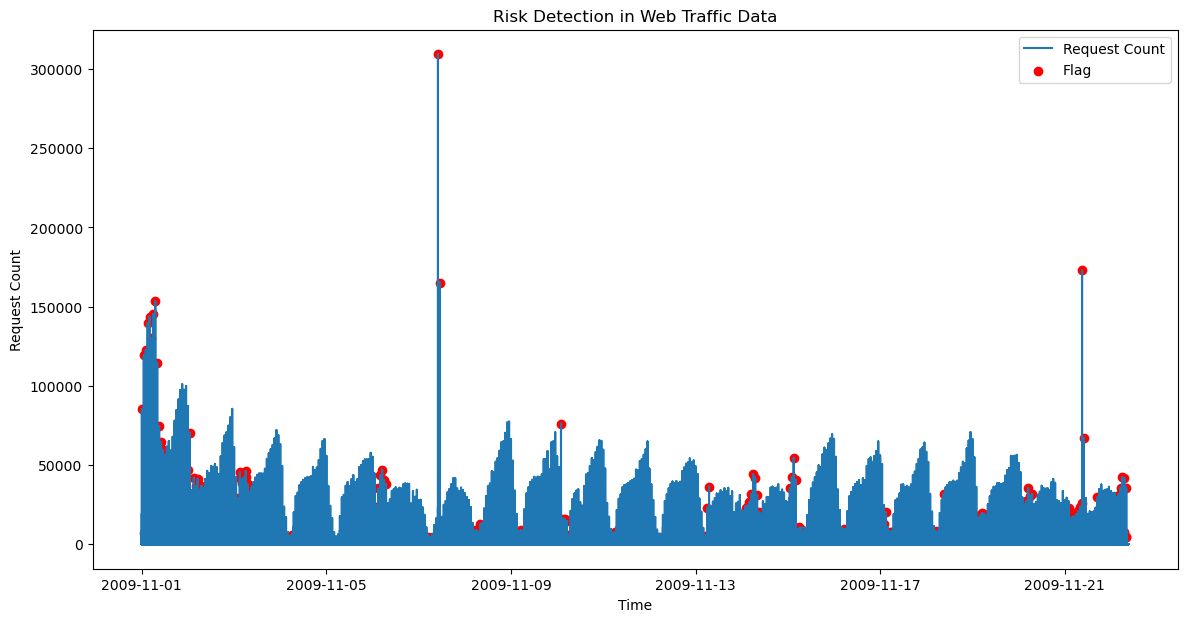

In [73]:
plt.figure(figsize=(14, 7))
plt.plot(plot_df['date_time'], plot_df['count'], label='Request Count')
plt.scatter(plot_df[plot_df['cluster_flag'] != 'Normal']['date_time'], 
            plot_df[plot_df['cluster_flag'] != 'Normal']['count'], 
            color='red', label='Flag')
plt.xlabel('Time')
plt.ylabel('Request Count')
plt.title('Risk Detection in Web Traffic Data')
plt.legend()
plt.show()

# Conclusion
- In this analysis of Indiana University's web traffic data from November 2009, spanning 21 days and over 22 million rows, we uncovered several key insights. Direct traffic accounted for the majority of clicks (13.8%), followed by search engine referrals (9%) and social network referrals (10.7%), with Facebook being the most common destination. An anomaly on November 7th, linked to bummas.com, was identified alongside 22,000 additional anomalies using Isolation Forest. Traffic prediction efforts reduced the model's error rate from 12.5% to 11%, while KMeans clustering revealed 11 behavioral clusters, with three exhibiting high average traffic counts flagged as risky. Across the 21 days, 376 instances of risky traffic were identified, offering valuable insights into traffic patterns, risks, and opportunities for optimization.